In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [2]:
import random
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.datasets import CIFAR100
from torchvision.transforms import ToTensor
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

In [3]:
np.random.seed(42)
torch.manual_seed(42)

In [4]:
class Baseline(nn.Module):
    def __init__(self):
        super(Baseline, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding="same")
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding="same")
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.bn1 = nn.BatchNorm2d(num_features=32)
        self.bn2 = nn.BatchNorm2d(num_features=32)
        self.dropout1 = nn.Dropout(p=0.2)
        
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding="same")
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding="same")
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        self.bn3 = nn.BatchNorm2d(num_features=64)
        self.bn4 = nn.BatchNorm2d(num_features=64)
        self.dropout2 = nn.Dropout(p=0.3)
        
        self.conv5 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding="same")
        self.conv6 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding="same")
        self.pool3 = nn.MaxPool2d(kernel_size=2)
        self.bn5 = nn.BatchNorm2d(num_features=128)
        self.bn6 = nn.BatchNorm2d(num_features=128)
        self.dropout3 = nn.Dropout(p=0.4)
        
        self.flatten = nn.Flatten()
        
        self.fc1 = nn.Linear(in_features=2048, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=128)
        self.fc3 = nn.Linear(in_features=128, out_features=128)
        self.fc4 = nn.Linear(in_features=128, out_features=128)
        self.bn7 = nn.BatchNorm1d(num_features=128)
        self.dropout4 = nn.Dropout(p=0.5)
        self.fc5 = nn.Linear(in_features=128, out_features=100)
        
        
    def forward(self, x):
        outputs = []
        x = self.conv1(x)
        x = F.relu(x)
        x = self.bn1(x)
        outputs.append(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.bn2(x)
        x = self.pool1(x)
        x = self.dropout1(x)
        outputs.append(x)
        
        x = self.conv3(x)
        x = F.relu(x)
        x = self.bn3(x)
        outputs.append(x)
        x = self.conv4(x)
        x = F.relu(x)
        x = self.bn4(x)
        x = self.pool2(x)
        x = self.dropout2(x)
        outputs.append(x)
        
        x = self.conv5(x)
        x = F.relu(x)
        x = self.bn5(x)
        outputs.append(x)
        x = self.conv6(x)
        x = F.relu(x)
        x = self.bn6(x)
        x = self.pool3(x)
        x = self.dropout3(x)
        outputs.append(x)
        
        x = self.flatten(x)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.relu(x)
        x = self.fc4(x)
        x = F.relu(x)
        x = self.bn7(x)
        x = self.dropout4(x)
        scores = self.fc5(x)
        
        return scores, outputs

In [5]:
class GeneralEEModel(nn.Module):
    def __init__(self):
        super(GeneralEEModel, self).__init__()
        self.pool_kernels = [
            (1, 4, 4), (1, 2, 2), (1, 2, 2), (1, 1, 1), (1, 1, 1)
        ]
#         self.conv = nn.Conv2d(in_channels=320, out_channels=16, kernel_size=3, padding="same")
#         self.bn = nn.BatchNorm2d(num_features=16)
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(in_features=20480, out_features=100)
    
    def forward(self, x, inference=False):
        pooled_outs = []
        for layer, out in enumerate(x):
            pool_3d = nn.MaxPool3d(kernel_size=self.pool_kernels[layer])
            pooled_outs.append(pool_3d(out))
        x = torch.cat(pooled_outs, dim=1)
#         if not inference:
#             indices = list(np.arange(x.shape[1]))
#             random.shuffle(indices)
#             x = x[:, indices, :, : ]
#         x = self.conv(x)
#         x = F.relu(x)
#         x = self.bn(x)
        x = self.flatten(x)
        scores = self.fc(x)
        return scores

In [6]:
def train(baseline, exit_model, layer, epochs, criterion, 
          optimizer, train_loader, val_loader, model_name, gen_ee=False):
    best_val_epoch, best_val_loss = 0, 1e6
    break_flag = 0
    for epoch in range(epochs):  # loop over the dataset multiple times
        exit_model.train()
        t_loss = 0
        correct = 0
        total = 0
        for i, data in enumerate(train_loader):
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            _, outs = baseline(images)
            if gen_ee:
                outs, choice = simulate_exit(outs)
                out = outs
            else:
                out = outs[layer]
            outputs = exit_model(out)
            loss = criterion(outputs, labels)
            t_loss += loss.item()
            loss.backward()
            optimizer.step()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        t_loss = t_loss / (i+1)
        t_loss = round(t_loss, 5)
        t_acc = round(100*(correct / total), 5)
        exit_model.eval()
        v_loss = 0
        correct = 0
        total = 0
        for i, data in enumerate(val_loader):
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            _, outs = baseline(images)
            if gen_ee:
                outs, choice = simulate_exit(outs)
                out = outs
            else:
                out = outs[layer]
            outputs = exit_model(out)
            loss = criterion(outputs, labels)
            v_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        v_loss = v_loss/(i+1)
        v_loss = round(v_loss, 5)
        v_acc = round(100*(correct / total), 5)
        if v_loss <= best_val_loss:
            torch.save(exit_model.state_dict(), model_name)
            best_val_epoch = epoch + 1
            best_val_loss = v_loss
            break_flag = 0
        else:
            break_flag += 1
        print(f'Epoch[{epoch+1}]: t_loss: {t_loss} t_acc: {t_acc} v_loss: {v_loss} v_acc: {v_acc}')
        if break_flag >19 :
            break
    print('Finished Training')
    print('Best model saved at epoch: ', best_val_epoch)

In [8]:
def simulate_exit(x, choice=None):
    if choice is not None:
        choice = choice
    else:
        choice = np.random.choice(np.arange(0, 5), p=[.3, .3, .2, .1, .1])
    batch_size = x[0].shape[0]
    reshaped_output = []
    for i in range(5):
        if i <= choice :
            reshaped_output.append(x[i])
        else:
            reshaped_output.append(torch.zeros_like(x[i]))
    return reshaped_output, choice

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [10]:
dataset = CIFAR100(root='./data', download=True, transform=ToTensor())
test_dataset = CIFAR100(root='./data', train=False, transform=ToTensor())

Files already downloaded and verified


In [11]:
batch_size=32
val_size = 5000
train_size = len(dataset) - val_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size*2, num_workers=4)

In [12]:
baseline = Baseline().to(device)
baseline.load_state_dict(torch.load("cifar100_baseline_m.h5", map_location='cpu'))
ee_model_name = "cifar100_ee_m.h5"
baseline.eval()

Baseline(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.3, inplace=False)
  (conv5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)

In [13]:
result_dict = {}
result_dict["accuracy"] = []
in_features = [0]
for ii, in_feature in enumerate(in_features):
    precisions, recall, f1 = [], [], []
    learning_rate = 5e-3
    exit_model = GeneralEEModel().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(exit_model.parameters(), lr=learning_rate, momentum=0.9)
    epochs = 100
    ee_model_name = "gen_ee_cifar100_m_5_new.h5"
    train(baseline, exit_model, ii, epochs, criterion, optimizer, 
          train_loader, val_loader, ee_model_name, gen_ee=True)
    exit_model.load_state_dict(torch.load(ee_model_name, map_location='cpu'))
    exit_model.eval()
    correct = 0
    total = 0
    with torch.no_grad(): 
        true_y, pred_y = [], []
        for i, data in enumerate(test_loader):
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            _, outs = baseline(images)
            outputs = exit_model(outs[:-1], inference=True)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            pred_y = pred_y + list(predicted.detach().cpu().numpy())
            true_y = true_y + list(labels.detach().cpu().numpy())
        report = classification_report(true_y, pred_y, output_dict=True)
        result_dict["accuracy"].append(report["accuracy"])
        for i, (key, value) in enumerate(report.items()):
            if i < 10:
                precisions.append(value['precision'])
                recall.append(value['recall'])
                f1.append(value['f1-score'])
        result_dict[ii] = {
            'precision': precisions,
            'recall': recall,
            'f1': f1,
            'conf_mat': confusion_matrix(true_y, pred_y)
        }

Epoch[1]: t_loss: 16.85097 t_acc: 17.63333 v_loss: 16.41305 v_acc: 23.08
Epoch[2]: t_loss: 12.64308 t_acc: 28.72222 v_loss: 15.32467 v_acc: 26.42
Epoch[3]: t_loss: 10.86068 t_acc: 33.67111 v_loss: 13.18464 v_acc: 26.56
Epoch[4]: t_loss: 9.45269 t_acc: 38.63333 v_loss: 14.12759 v_acc: 27.06
Epoch[5]: t_loss: 8.5258 t_acc: 41.58667 v_loss: 13.20477 v_acc: 28.16
Epoch[6]: t_loss: 7.59561 t_acc: 43.92667 v_loss: 14.05838 v_acc: 29.08
Epoch[7]: t_loss: 7.20747 t_acc: 46.13333 v_loss: 13.75427 v_acc: 32.24
Epoch[8]: t_loss: 6.6672 t_acc: 49.18444 v_loss: 14.80252 v_acc: 30.66
Epoch[9]: t_loss: 5.9098 t_acc: 50.93778 v_loss: 14.25201 v_acc: 31.76
Epoch[10]: t_loss: 5.70042 t_acc: 51.68222 v_loss: 14.87569 v_acc: 31.0
Epoch[11]: t_loss: 5.16923 t_acc: 54.09111 v_loss: 14.40767 v_acc: 30.68
Epoch[12]: t_loss: 4.92683 t_acc: 56.76 v_loss: 12.82444 v_acc: 31.32
Epoch[13]: t_loss: 4.49723 t_acc: 58.24444 v_loss: 14.43257 v_acc: 33.62
Epoch[14]: t_loss: 4.25457 t_acc: 59.39556 v_loss: 14.04179 v_ac

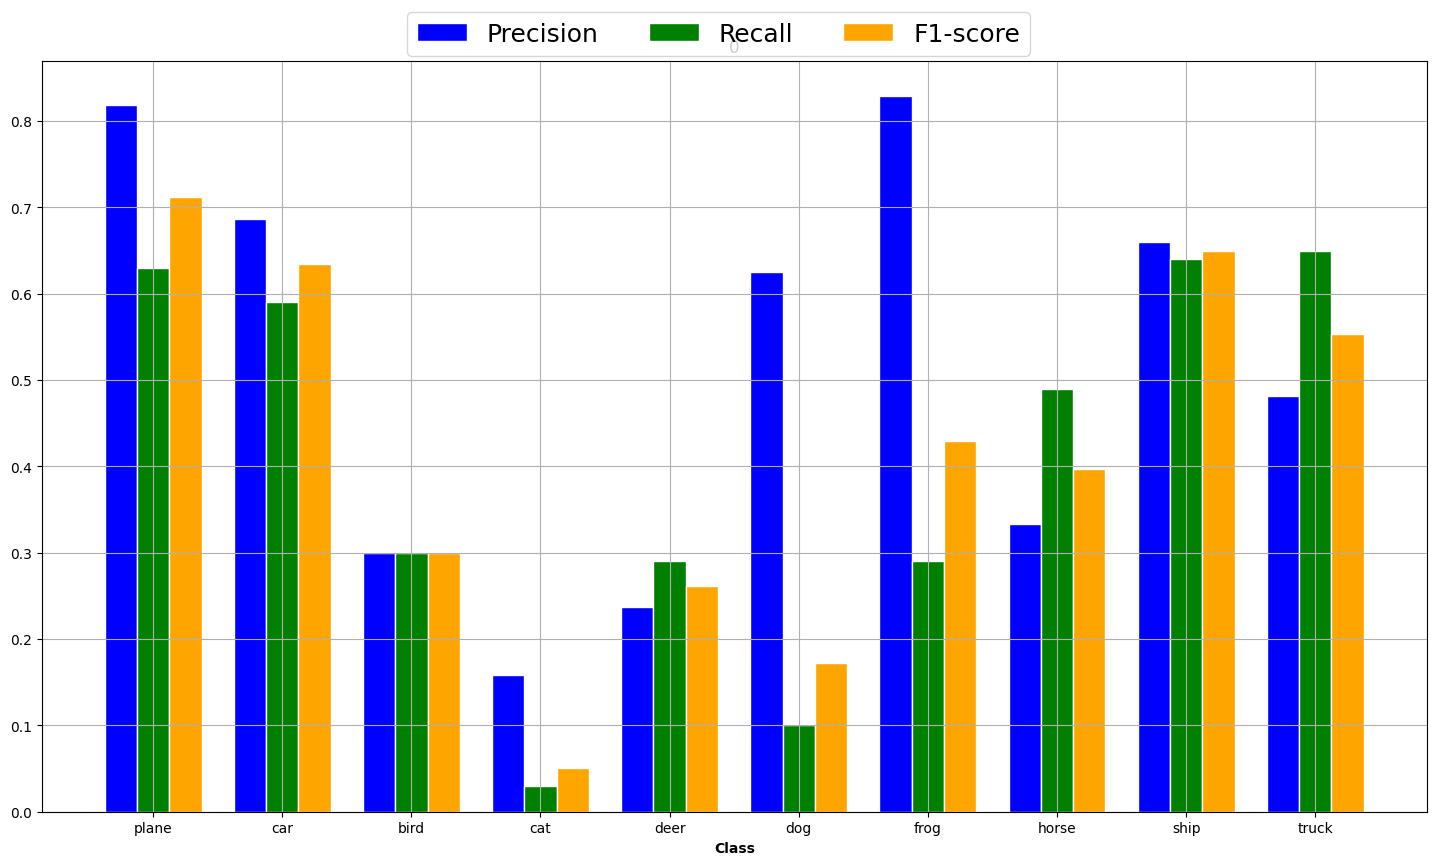

In [14]:
fig, ax = plt.subplots(len(in_features), 1, figsize=(15, 9))
class_names = ['plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck']
bar_width = 0.25
i = 0
precisions = result_dict[i]['precision']
recall = result_dict[i]['recall']
f1 = result_dict[i]['f1']
r1 = np.arange(len(precisions))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]
ax.bar(r1, precisions, color='blue', width=bar_width, edgecolor='white', label='Precision')
ax.bar(r2, recall, color='green', width=bar_width, edgecolor='white', label='Recall')
ax.bar(r3, f1, color='orange', width=bar_width, edgecolor='white', label='F1-score')
ax.set_title(str(i))
ax.set_xticks([r + bar_width for r in range(len(precisions))], class_names)
ax.grid()
plt.xlabel('Class', fontweight='bold')
lines_labels = [ax.get_legend_handles_labels()]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc="upper center", ncol=3, fontsize=18)
plt.tight_layout(pad=3)
plt.show()

In [15]:
accuracies = []
for choice in range(5):
    true_y, pred_y = [], []
    for i, data in enumerate(test_loader):
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        _, outs = baseline(images)
        outs, _ = simulate_exit(outs, choice=choice)
        outputs = exit_model(outs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        pred_y = pred_y + list(predicted.detach().cpu().numpy())
        true_y = true_y + list(labels.detach().cpu().numpy())
    report = classification_report(true_y, pred_y, output_dict=True)
    accuracies.append(report["accuracy"])
    print(f'Layer: {choice+1} | Accuracy: {report["accuracy"]}')

Layer: 1 | Accuracy: 0.2462


/hdd/subrata/TinyML/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/hdd/subrata/TinyML/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/hdd/subrata/TinyML/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Layer: 2 | Accuracy: 0.3113
Layer: 3 | Accuracy: 0.3658
Layer: 4 | Accuracy: 0.404
Layer: 5 | Accuracy: 0.428


In [16]:
accuracies

[0.2462, 0.3113, 0.3658, 0.404, 0.428]